In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install emoji
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import re
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/VK/'

In [5]:
train_data_path = path + 'train_spam.csv'
train_data = pd.read_csv(train_data_path)

In [6]:
test_data_path = path + 'test_spam.csv'
test_data = pd.read_csv(test_data_path)

In [7]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [9]:
train_data.describe(include='all')

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


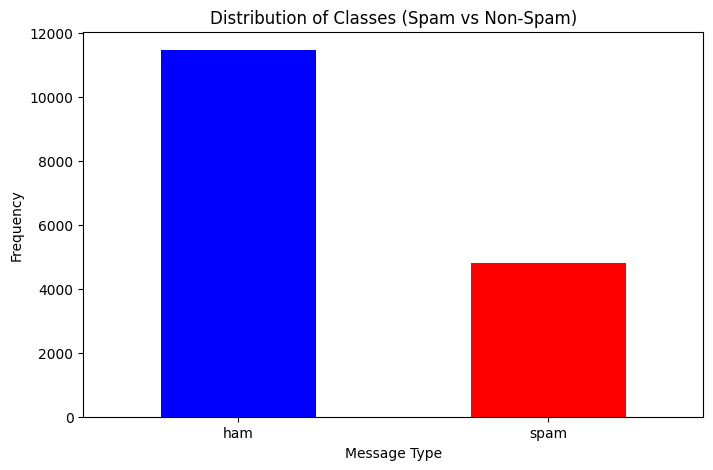

In [10]:
class_distribution = train_data['text_type'].value_counts()

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Message Type')
plt.ylabel('Frequency')
plt.title('Distribution of Classes (Spam vs Non-Spam)')
plt.xticks(rotation=0)
plt.show()

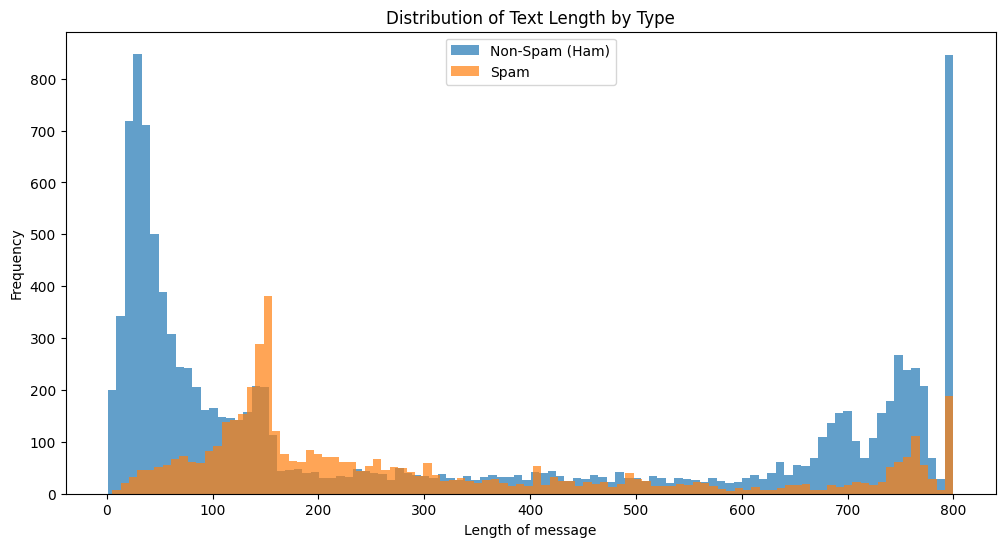

In [11]:
train_data['text_length'] = train_data['text'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(train_data[train_data['text_type'] == 'ham']['text_length'], bins=100, alpha=0.7, label='Non-Spam (Ham)')
plt.hist(train_data[train_data['text_type'] == 'spam']['text_length'], bins=100, alpha=0.7, label='Spam')
plt.xlabel('Length of message')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length by Type')
plt.legend()
plt.show()

In [12]:
def convert_emojis(text):
    text_with_emojis = emoji.demojize(text, delimiters=(" ", " "))
    text_with_emojis = re.sub(r'(:[^: ]+:)(?=:)', r'\1 ', text_with_emojis)
    return text_with_emojis

In [13]:
train_data['processed_text'] = train_data['text'].apply(convert_emojis)

In [14]:
test_data['processed_text'] = test_data['text'].apply(convert_emojis)

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct])

In [16]:
train_data['processed_text'] = train_data['processed_text'].apply(preprocess_text)

In [17]:
test_data['processed_text'] = test_data['processed_text'].apply(preprocess_text)

In [18]:
train_data['processed_text_length'] = train_data['processed_text'].apply(len)

In [19]:
test_data['processed_text_length'] = test_data['processed_text'].apply(len)

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

In [21]:
tfidf_vectorizer.fit(train_data['processed_text'])

TfidfVectorizer(max_features=5000, stop_words='english')

In [22]:
train_tfidf = tfidf_vectorizer.transform(train_data['processed_text'])

In [23]:
test_tfidf = tfidf_vectorizer.transform(test_data['processed_text'])

In [24]:
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [25]:
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [26]:
train_features = pd.concat([train_tfidf_df, train_data['processed_text_length'].reset_index(drop=True)], axis=1)

In [27]:
test_features = pd.concat([test_tfidf_df, test_data['processed_text_length'].reset_index(drop=True)], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_data['text_type'], test_size=0.2, random_state=42, stratify=train_data['text_type'])

In [29]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

In [30]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_val, y_val)

In [31]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, auto_class_weights='Balanced', eval_metric='AUC', use_best_model=True, random_seed=42, verbose=10)

In [32]:
model.fit(train_pool, eval_set=validate_pool)

0:	test: 0.8670629	best: 0.8670629 (0)	total: 522ms	remaining: 51.6s
10:	test: 0.9343671	best: 0.9343671 (10)	total: 2.7s	remaining: 21.8s
20:	test: 0.9507358	best: 0.9507358 (20)	total: 5.93s	remaining: 22.3s
30:	test: 0.9562906	best: 0.9562906 (30)	total: 10s	remaining: 22.3s
40:	test: 0.9624063	best: 0.9624063 (40)	total: 12.8s	remaining: 18.4s
50:	test: 0.9654195	best: 0.9654741 (49)	total: 14.9s	remaining: 14.3s
60:	test: 0.9680547	best: 0.9680547 (60)	total: 17.1s	remaining: 10.9s
70:	test: 0.9698274	best: 0.9698274 (70)	total: 19.2s	remaining: 7.84s
80:	test: 0.9713478	best: 0.9713478 (80)	total: 21.3s	remaining: 5s
90:	test: 0.9730819	best: 0.9730819 (90)	total: 25.2s	remaining: 2.49s
99:	test: 0.9744312	best: 0.9744312 (99)	total: 28.9s	remaining: 0us

bestTest = 0.9744312122
bestIteration = 99



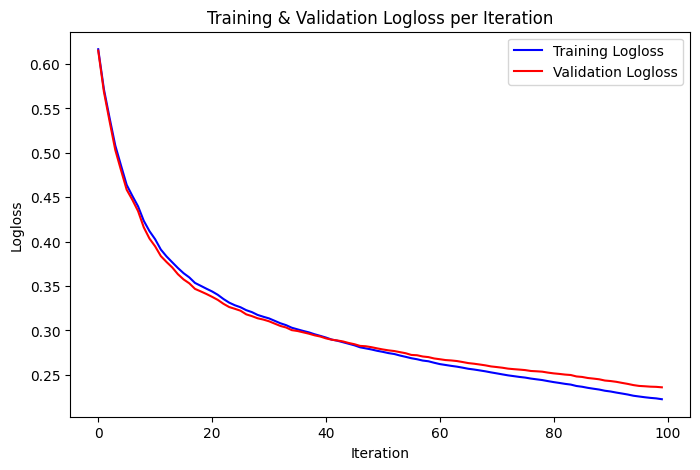

In [33]:
train_logloss = model.evals_result_['learn']['Logloss']
valid_logloss = model.evals_result_['validation']['Logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_logloss, label='Training Logloss', color='blue')
plt.plot(valid_logloss, label='Validation Logloss', color='red')
plt.title('Training & Validation Logloss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.legend()
plt.show()

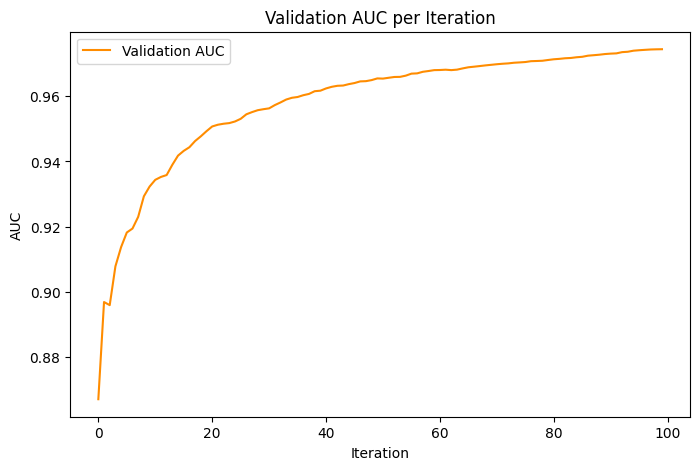

In [34]:
valid_auc = model.evals_result_['validation']['AUC']

plt.figure(figsize=(8, 5))
plt.plot(valid_auc, label='Validation AUC', color='darkorange')
plt.title('Validation AUC per Iteration')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [35]:
y_pred = model.predict_proba(X_test)[:, 1]

In [36]:
auc_score = roc_auc_score(y_test, y_pred)

In [37]:
print(f'Test ROC-AUC Score: {auc_score}')

Test ROC-AUC Score: 0.980256696806529


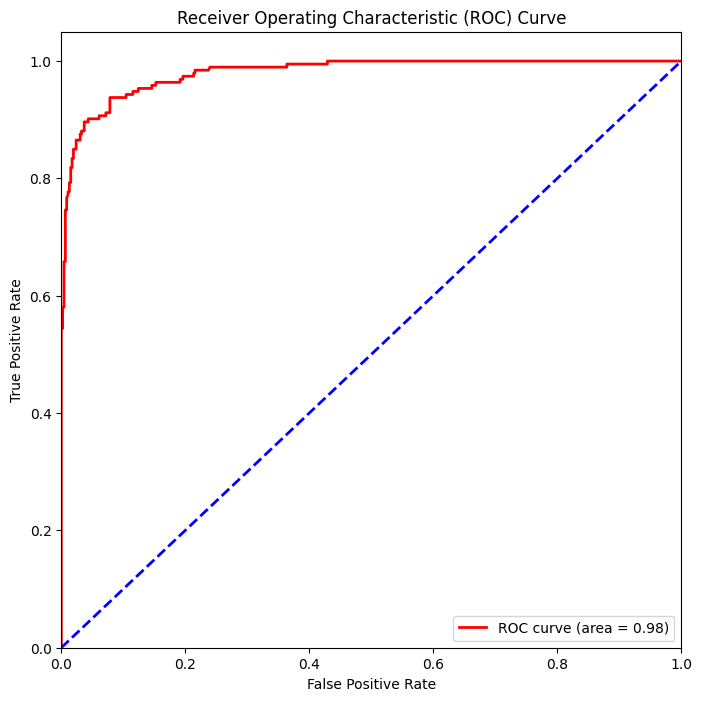

In [38]:
y_true = y_test
y_scores = y_pred

le = LabelEncoder()

y_true_encoded = le.fit_transform(y_test)

fpr, tpr, thresholds = roc_curve(y_true_encoded, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
y_pred = model.predict_proba(test_features)[:, 1]

In [40]:
results_df = pd.DataFrame({
    'text': test_data['text'],
    'probability': y_pred
})

results_df['predicted_class'] = (results_df['probability'] > 0.5).astype(int)

results_df['predicted_class'] = results_df['predicted_class'].map({0: 'not spam', 1: 'spam'})

results_df.to_csv('spam_predictions_tf_idf.csv', index=False)

results_df.head()

,text,probability,predicted_class
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.220997,not spam
1,original message from bitbitch magnesium net p...,0.606723,spam
2,java for managers vince durasoft who just taug...,0.015797,not spam
3,there is a youtuber name saiman says,0.020291,not spam
4,underpriced issue with high return on equity t...,0.684273,spam
